# EXERCISES SECOND PART JUAN IGNACIO CABALLERO


## LIBRARIES

In [2]:
import numpy as np
import skimage
from skimage.color import rgb2gray
from  skimage.segmentation import watershed

import scipy
import pandas as pd
 

import importlib


from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import napari
from napari.utils import nbscreenshot
%gui qt5

## EXERCISES

## 1 Extract contour of an image

In [2]:
# This should adjust automatically the path i for the files 
ref_path = Path().resolve()

print('Your path used as local reference:\n',ref_path)

Your path used as local reference:
 D:\OneDrive - Universidad Politécnica de Madrid\Z_Otros\Asignaturas\Procesamiento de imagenes\git_exercises_0-9


In [3]:
# Declaring the paths to the folders of work

# Example of my path
# folder_to_read = Path(r"D:\OneDrive - Universidad Politécnica de Madrid\Z_Otros\Asignaturas\Procesamiento de imagenes\python_folder")

# Your path should be solved with this:
folder_to_read = Path(ref_path /  "Part2_exercises")
print('This is your path to read the images\n',str(folder_to_read))

This is your path to read the images
 D:\OneDrive - Universidad Politécnica de Madrid\Z_Otros\Asignaturas\Procesamiento de imagenes\git_exercises_0-9\Part2_exercises


In [6]:
## Name of the files
name1 = 'cameraman.png'

ruta_data1 = folder_to_read / name1

## Reading the image,
# this is a method to import the image in the python environment 
with Image.open(str(ruta_data1), mode='r') as img:
    img1 = np.array(img)

## Napari is a visualization program that is displayed outside the jupyter
# This opens a viewer object with the image img1
viewer = napari.view_image(img1)

## Segmentation in gray level

### Functions of the first part of the course

In [4]:
def umbral(img,value):
    img2 = img.copy()
    img2[img2<value] = 0
    img2[img2>=value] = 255
    
    return img2

'''
Neighbours:
    It computes the neighbours of each pixel. Identifying each of them
    
    vec_array2d: Its the area of the image where the neighbours are computed
    
    vec_array2d has size factor of array2D size: 
    --> size(vec_array) es factor de size(array2d)
    
    The vec_array needs to be flattened to be an input.
    
    output: list of the each type of neighbour and the value of the pixels.
    When in an edge the result is nan
'''    
def neighbours(array2d, vec_array2d):
    vec_array2d_lf = []
    vec_array2d_rg = []
    vec_array2d_up = []
    vec_array2d_dw = []
 
 # Valores a la izda, derecha, arriba y abajo de cada pixel. Estan a una distancia periodica. 
    for i in range(len(vec_array2d)):
        if (i - array2d.shape[1])< 0:
            vec_array2d_lf.append(np.nan)  #Borde de imagen tienen nan
        else:
            vec_array2d_lf.append(vec_array2d[i - array2d.shape[1]])

    for i in range(len(vec_array2d)):
        if (i + array2d.shape[1])>= vec_array2d.size: # hay que restar 1 por empezar en 0
            vec_array2d_rg.append(np.nan)  #Borde de imagen tienen nan
        else:
            vec_array2d_rg.append(vec_array2d[i + array2d.shape[1]])

    for i in range(len(vec_array2d)):
        if i % array2d.shape[1] == 0:
            vec_array2d_up.append(np.nan)  #Borde de imagen tienen nan
        else:
            vec_array2d_up.append(vec_array2d[i - 1])

    for i in range(len(vec_array2d)):
        if i in np.arange(array2d.shape[1]-1, vec_array2d.size+array2d.shape[1], array2d.shape[1]):
            vec_array2d_dw.append(np.nan)  #Borde de imagen tienen nan
        else:
            vec_array2d_dw.append(vec_array2d.flatten('C')[i + 1])

    # Diagonales
    ##Miro los up y down de la columna a izda y derecha.
    diag_iz_up = []
    diag_iz_do = []
    diag_de_up = []
    diag_de_do = []

    for i in range(len(vec_array2d)):
        if ((pd.isnull(vec_array2d_lf[i])) or (pd.isnull(vec_array2d_up[i]))):
            diag_iz_up.append(np.nan)  #Borde de imagen tienen nan
        else:
            diag_iz_up.append(vec_array2d[i - array2d.shape[1]-1])
    for i in range(len(vec_array2d)):
        if i in np.arange(array2d.shape[1]-1,vec_array2d.size+array2d.shape[1],array2d.shape[1]) or ((i - array2d.shape[1]+1)<0):
            diag_iz_do.append(np.nan)  #Borde de imagen tienen nan
        else:
            diag_iz_do.append(vec_array2d[i - array2d.shape[1]+1])
    for i in range(len(vec_array2d)):
        if ((i + array2d.shape[1])>= vec_array2d.size) or (i % array2d.shape[1] == 0):
            diag_de_up.append(np.nan)  #Borde de imagen tienen nan
        else:
            diag_de_up.append(vec_array2d[i + array2d.shape[1]-1])
    for i in range(len(vec_array2d)):
        if ((i + array2d.shape[1])>= vec_array2d.size) or (i in np.arange(array2d.shape[1]-1, vec_array2d.size+array2d.shape[1], array2d.shape[1])): # hay que restar 1 por empezar en 0
            diag_de_do.append(np.nan)  #Borde de imagen tienen nan
        else:
            diag_de_do.append(vec_array2d[i + array2d.shape[1]+1])
    
    return (vec_array2d_lf,vec_array2d_rg,vec_array2d_up,vec_array2d_dw,diag_iz_up,diag_iz_do,diag_de_up,diag_de_do)

# An opening is an erosion followed by an dilation.
def erosion(img, filtro1d):
    '''
    Filtro refers to the 2D array that may be a subarea of the image. it follows the limitation of neighbours func. Usually its the whole image
    '''
    alln = neighbours(img,filtro1d)
    ## Adding image pixels, alln only has the neighbours of each pixel
    alln = list(alln)
    alln.append(img.flatten().tolist())
    # we need an array type to be analysed along axis
    alln = np.array(alln)
    # computing the min value.
    ero_img = np.nanmin(alln,axis=0).reshape(img.shape)
    return ero_img

def dilation(img, filtro1d):
    '''
    Filtro refers to the 2D array that may be a subarea of the image. it follows the limitation of neighbours func. Usually its the whole image
    '''
    alln = neighbours(img,filtro1d)
    ## Adding image pixels, alln only has the neighbours of each pixel
    alln = list(alln)
    alln.append(img.flatten().tolist())
    # we need an array type to be analysed along axis
    alln = np.array(alln)
    # computing the min value.
    ero_img = np.nanmax(alln,axis=0).reshape(img.shape)
    return ero_img

def opening(img,filtro1d):
    resul = erosion(img,filtro1d)
    resul = dilation(resul,resul.flatten())
    return resul

def closing(img,filtro1d):
    resul = dilation(img,filtro1d)
    resul = erosion(resul,resul.flatten())
    return resul

In [20]:
## png has 3 channels but the image is in grayscale
# We get one channel
img1 = img1[:,:,0]
ero_camera = erosion(img1,img1.flatten())

In [21]:
viewer.add_image(ero_camera)
ero_cont = img1-ero_camera
viewer.add_image(ero_cont)

<Image layer 'ero_cont' at 0x1acc6f90648>

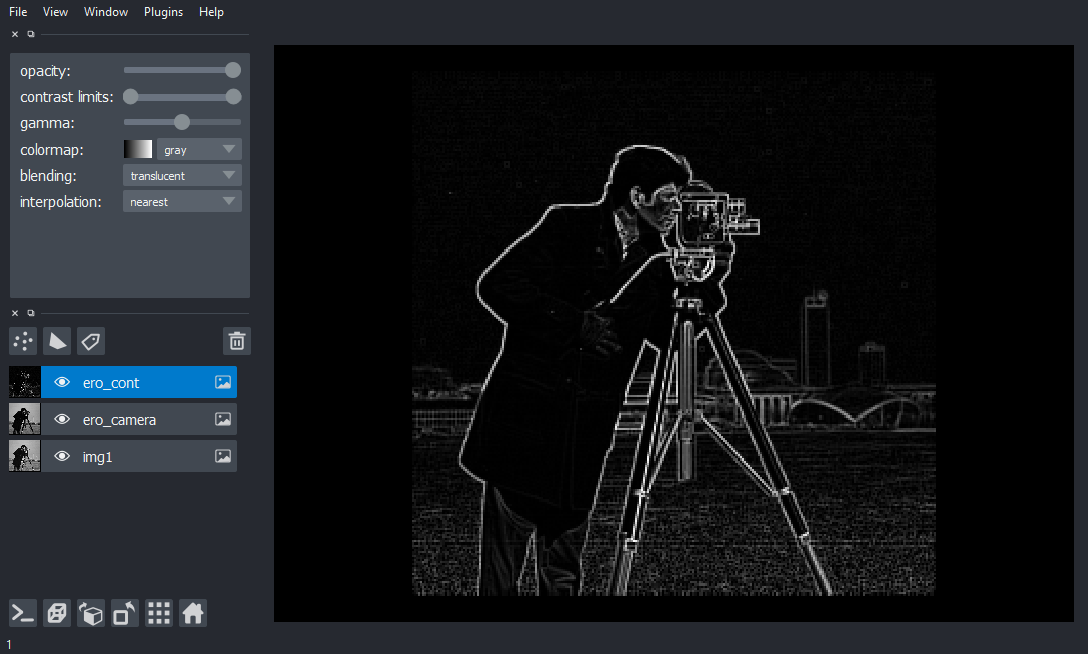

In [22]:
nbscreenshot(viewer)

In [23]:
dil_camera = dilation(img1,img1.flatten())
dil_cont = img1-dil_camera
viewer.add_image(dil_cont)

<Image layer 'dil_cont' at 0x1acc65f3148>

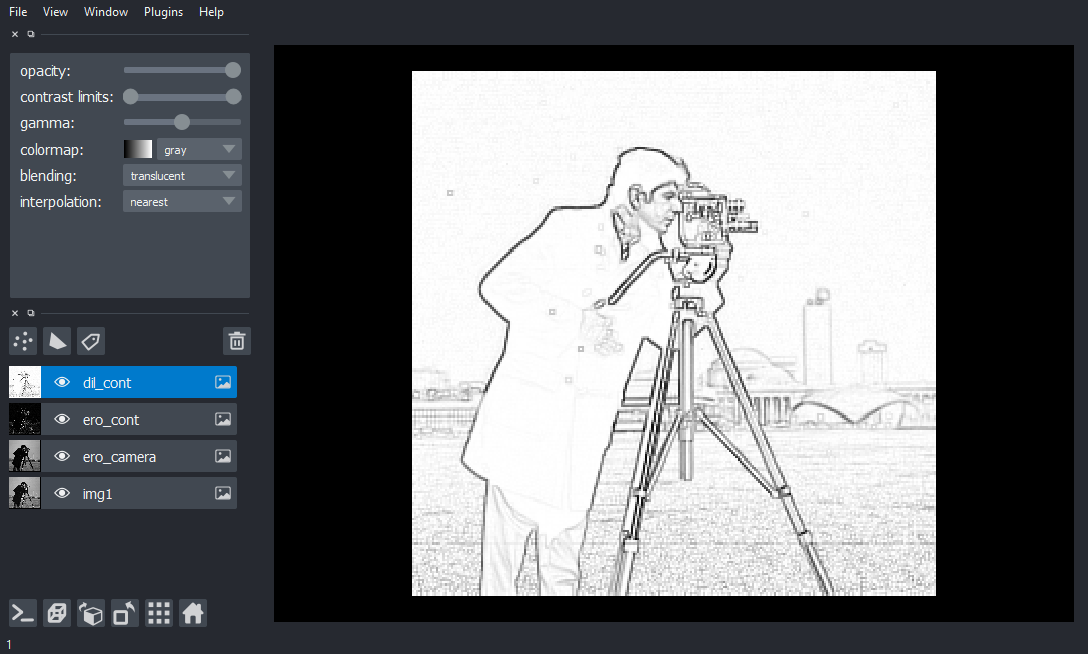

In [24]:
nbscreenshot(viewer)

## 2 Implement the grassfire algorithm

## 3.a Count wheelteeth


In [15]:
## Name of the files
name4 = 'wheel.png'


ruta_data4 = folder_to_read / name4

## Reading the image,
with Image.open(str(ruta_data4), mode='r') as img:
    img4 = np.array(img)

## Napari is a visualization program that is displayed outside the jupyter
# This opens a viewer object with the image img1
viewer4 = napari.view_image(img4)


In [16]:
def opening(img,i):
    resul = img
    for ii in range(i):
        resul = erosion(resul,resul.flatten())
        
    for ii in  range(i):
        resul = dilation(resul,resul.flatten())
    return resul

def closing(img,i):
    resul = img
    for ii in range(i):
        resul = dilation(resul,resul.flatten())
        
    for ii in  range(i):
        resul = erosion(resul,resul.flatten())
    return resul

def alt_closing_opening(img,iclo,iope):
    resul = closing(img,iclo)
    resul = opening(resul,iope)
    return resul

def alt_opening_closing(img,iclo,iope):
    
    resul = opening(img,iope)
    resul = closing(resul,iclo)
    return resul

In [32]:
# Opening to obtain a smoothed image
ope_img4 = opening(img4,5)
viewer4.add_image(ope_img4)

<Image layer 'ope_img4 [2]' at 0x155bb85d848>

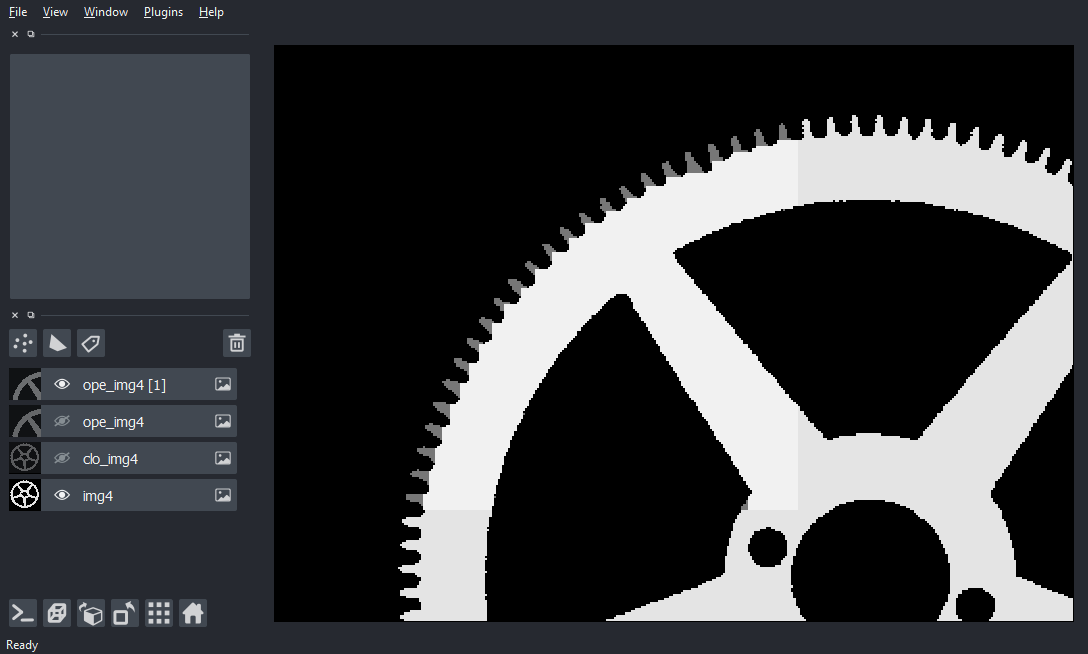

In [31]:
nbscreenshot(viewer4)

In [33]:
# Doing the difference between images
dif_img4 = img4 - ope_img4
labels = skimage.measure.label(dif_img4)
viewer4.add_labels(labels)
print('Total teeth count',np.max(labels))
# There is a large error due to pixels located in the interior of the wheel. We could use a mask and so on to improve the result.

Total teeth count 168


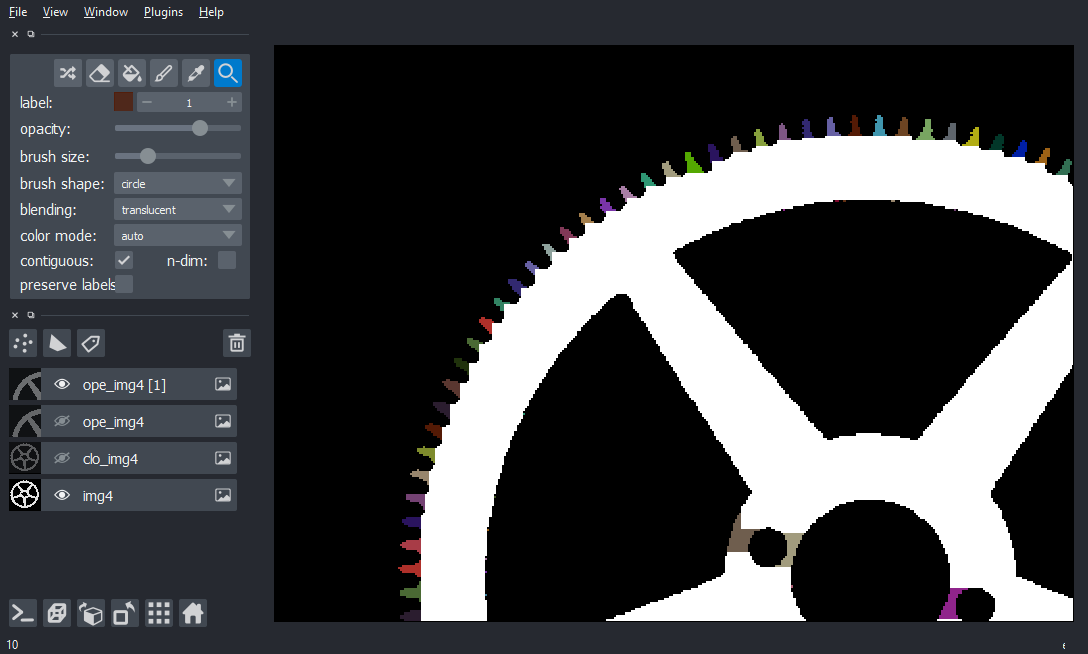

In [34]:
nbscreenshot(viewer4)

## Process description
1. Find the convex hull of the wheel. 

2. Erode the convex image (a circle) and substract to get the contour.

3. Get the number of common points in the convex hull contour and the wheel. Because there are more than one get connected regions with 8-connectivity.
(I did this methodology before, I decided to not delete the code.

In [9]:
## 1
from skimage.morphology import convex_hull_image

con_img4 = convex_hull_image(img4)
viewer4.add_image(con_img4)

<Image layer 'con_img4' at 0x2116f004808>

In [10]:
## 2.
ero_img4 = erosion(con_img4,con_img4.flatten())
dif_img4 = con_img4-ero_img4
viewer4.add_image(dif_img4)

<Image layer 'dif_img4' at 0x2117caa8ec8>

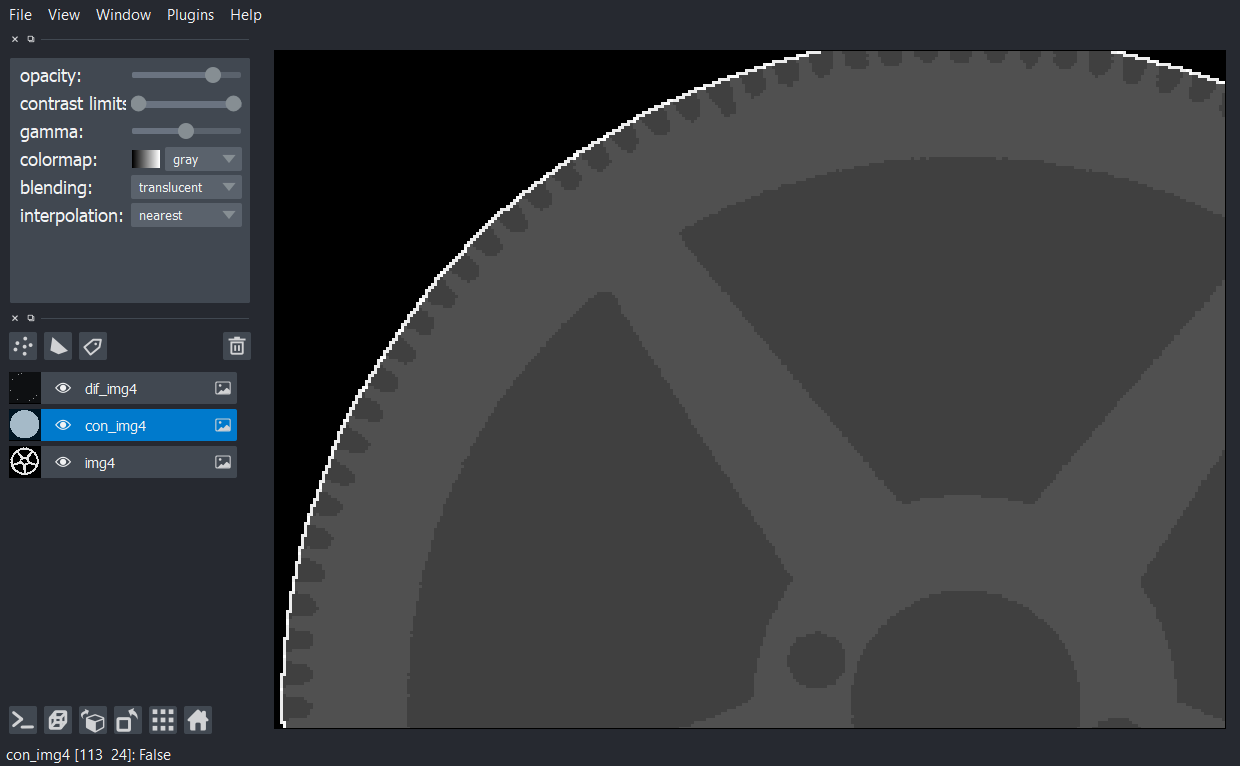

In [11]:
nbscreenshot(viewer4)

In [12]:
## 3
# Intersection of images: value img and two boolean arrays.
common_points = dif_img4 * (dif_img4>0) * (img4>0)
viewer4.add_image(common_points)

# Count connected regions
labels = skimage.measure.label(common_points)
viewer4.add_labels(labels)
print('Total teeth count',np.max(labels))

Total teeth count 120


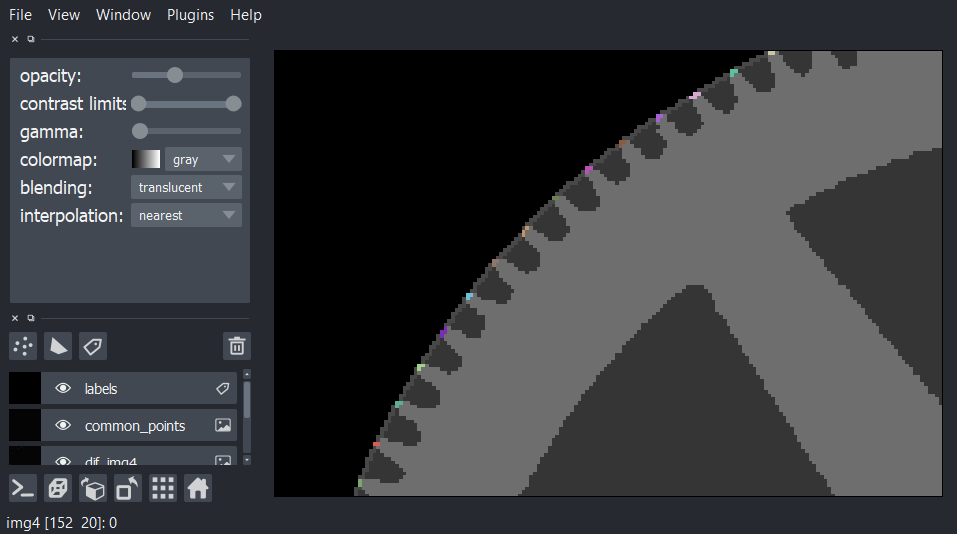

In [13]:
nbscreenshot(viewer4)

## 3.b Perform watershed
In the images: coffee_grains and coffee_grains_markers

### Note:
I am using the scikit-image implementation of the watershed algorithm.

In [5]:
## Name of the files
name2 = 'coffee_grains.jpg'
name3 = 'coffee_markers.png'

ruta_data2 = folder_to_read / name2
ruta_data3 = folder_to_read / name3

## Reading the image,
with Image.open(str(ruta_data2), mode='r') as img:
    img2 = np.array(img)

with Image.open(str(ruta_data3), mode='r') as img:
    img3 = np.array(img)

## Napari is a visualization program that is displayed outside the jupyter
# This opens a viewer object with the image img1
viewer2 = napari.view_image(img2)
viewer2.add_image(img3)

<Image layer 'img3' at 0x155a7418448>

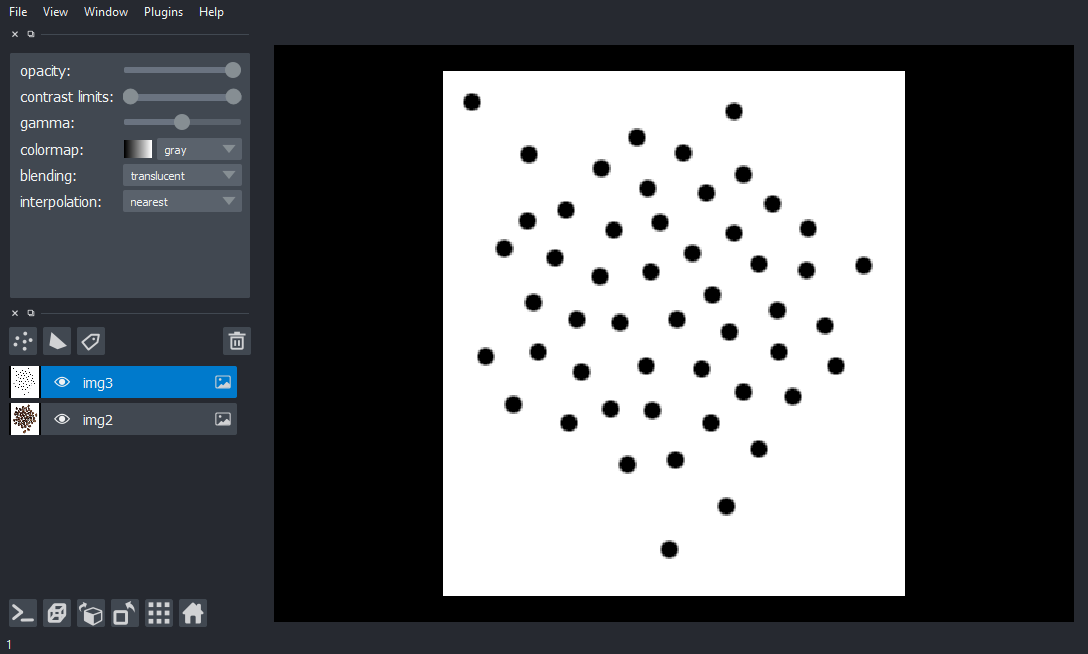

In [7]:
nbscreenshot(viewer2)

In [8]:
from skimage import util
test = watershed(util.invert(rgb2gray(img2)),rgb2gray(img3),connectivity=1)
viewer2.add_image(test)

<Image layer 'test' at 0x155b1258308>

In [9]:
# Invert the image to have background as 0
gray_img2 = util.invert(rgb2gray(img2))
viewer2.add_image(gray_img2)

<Image layer 'gray_img2' at 0x155b1267848>

In [10]:
# Threshold image
th_img2 = umbral(gray_img2,0.3)
viewer2.add_image(th_img2)

<Image layer 'th_img2' at 0x155b1383a08>

In [11]:
# Contour image
ero_img2 = erosion(th_img2,th_img2.flatten())
ero_dif = th_img2-ero_img2
viewer2.add_image(ero_dif)

<Image layer 'ero_dif' at 0x155b13a9688>

In [12]:
# Inverting the markers grayscale image
g_img3 = util.invert(rgb2gray(img3))
viewer2.add_image(g_img3)

<Image layer 'g_img3' at 0x155b143cc88>

In [13]:
test = watershed(ero_dif,markers=skimage.measure.label(g_img3),connectivity=1)
viewer2.add_labels(test)

<Labels layer 'test [1]' at 0x155b14eb3c8>

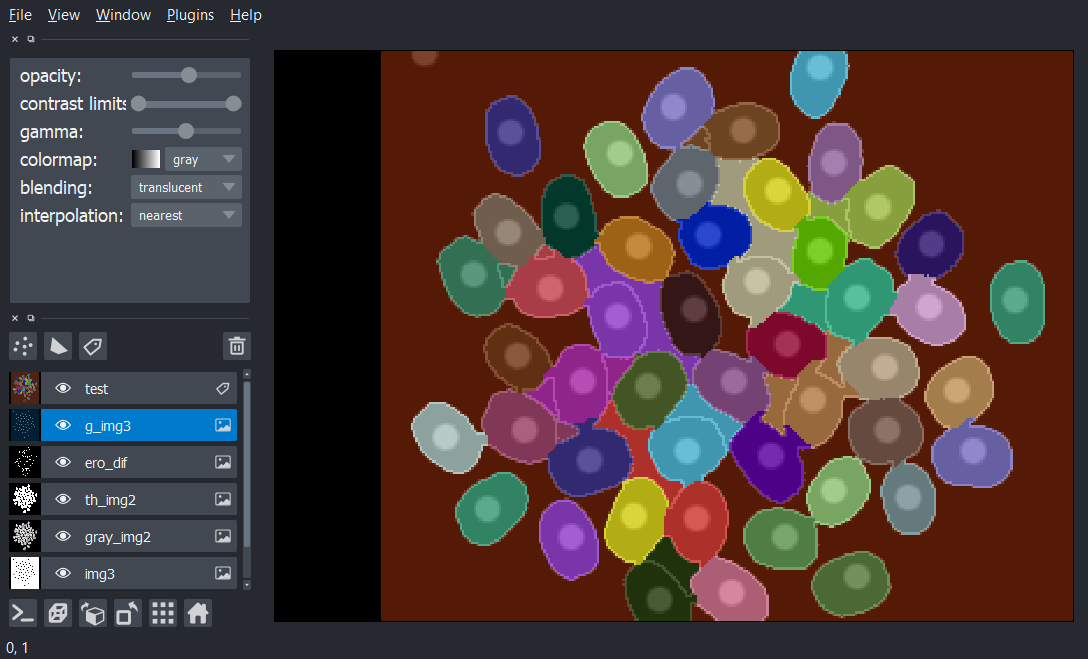

In [26]:
nbscreenshot(viewer2)

In [14]:
# I wanted to test the performance in the case the thresholded image was the input of the watershed.
test = watershed(th_img2,markers=skimage.measure.label(g_img3),connectivity=1)
viewer5 = napari.view_image(img2)
viewer5.add_image(skimage.measure.label(g_img3))
viewer5.add_image(th_img2)
viewer5.add_labe
ls(test)

<Labels layer 'test' at 0x155a8e6e9c8>

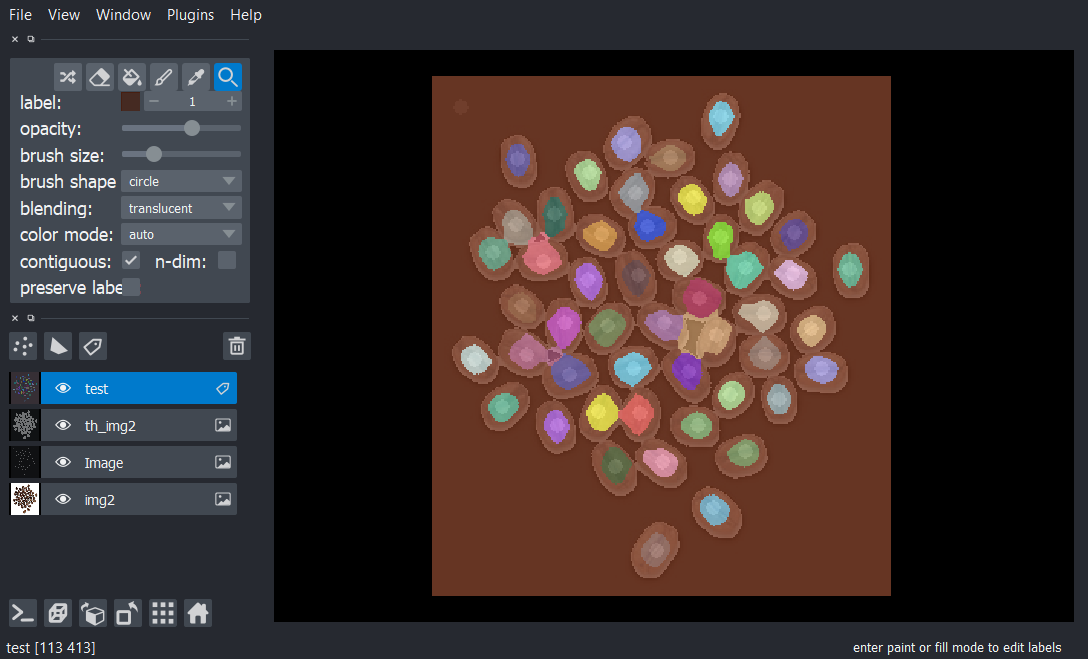

In [35]:
nbscreenshot(viewer5)